# Chapter 8
# Feature Importance Explanations

## Data Preparation

In [1]:
import math
import numpy as np
import pandas as pd

from sklearn import metrics, ensemble, tree, inspection
import catboost as cb

from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve, ConfusionMatrix
from yellowbrick.contrib.wrapper import wrap
import matplotlib.pyplot as plt 
import seaborn as sns
import shap

In [2]:
hdma_df = pd.read_csv('..//data/hmda.csv')

protected_cols = ['race', 'ethnicity', 'sex', 'black', 'asian', 'white', 'hispanic',\
                  'non_hispanic', 'native_american', 'hawaiian_or_pacific_islander',\
                  'female', 'male']
other_remove_cols = ['Unnamed: 0', 'cv_fold', 'low_priced','rate_spread',\
                     'debt_to_income_ratio_original','state','product_type',\
                     'agegte62', 'agelt62']
hdma_df.drop(protected_cols + other_remove_cols, axis=1, inplace=True)

hdma_df.to_csv('..//hmda_Ch8.csv', index=False)

In [3]:
hdma_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   train                      300000 non-null  object 
 1   high_priced                300000 non-null  float64
 2   interest_rate              300000 non-null  float64
 3   loan_amount                300000 non-null  float64
 4   loan_to_value_ratio        300000 non-null  float64
 5   no_intro_rate_period       300000 non-null  int64  
 6   intro_rate_period          300000 non-null  int64  
 7   property_value             300000 non-null  float64
 8   income                     300000 non-null  float64
 9   debt_to_income_ratio       300000 non-null  float64
 10  term_360                   300000 non-null  float64
 11  conforming                 300000 non-null  float64
 12  state_target_encoded       300000 non-null  float64
 13  product_type_conventional  30

In [4]:
rand = 42
class_l = ['low priced','high priced']

X = hdma_df.drop(['train','high_priced'], axis=1)
y = hdma_df['high_priced']

X_train, X_test = X[hdma_df.train == 'train'], X[hdma_df.train == 'valid']
y_train, y_test = y[hdma_df.train == 'train'], y[hdma_df.train == 'valid']

## Model Training & Evaluation

In [5]:
%%time
cb_mdl = cb.CatBoostClassifier(depth=6, learning_rate=0.1,\
                               random_state=rand, verbose=False)
cb_mdl = cb_mdl.fit(X_train, y_train)

rf_mdl = ensemble.RandomForestClassifier(n_jobs=-1, random_state=rand)
rf_mdl = rf_mdl.fit(X_train.to_numpy(), y_train.to_numpy())

CPU times: user 4min 1s, sys: 11.5 s, total: 4min 12s
Wall time: 39.5 s


In [6]:
cb_mdl.save_model('..//models/high_priced.cbm')

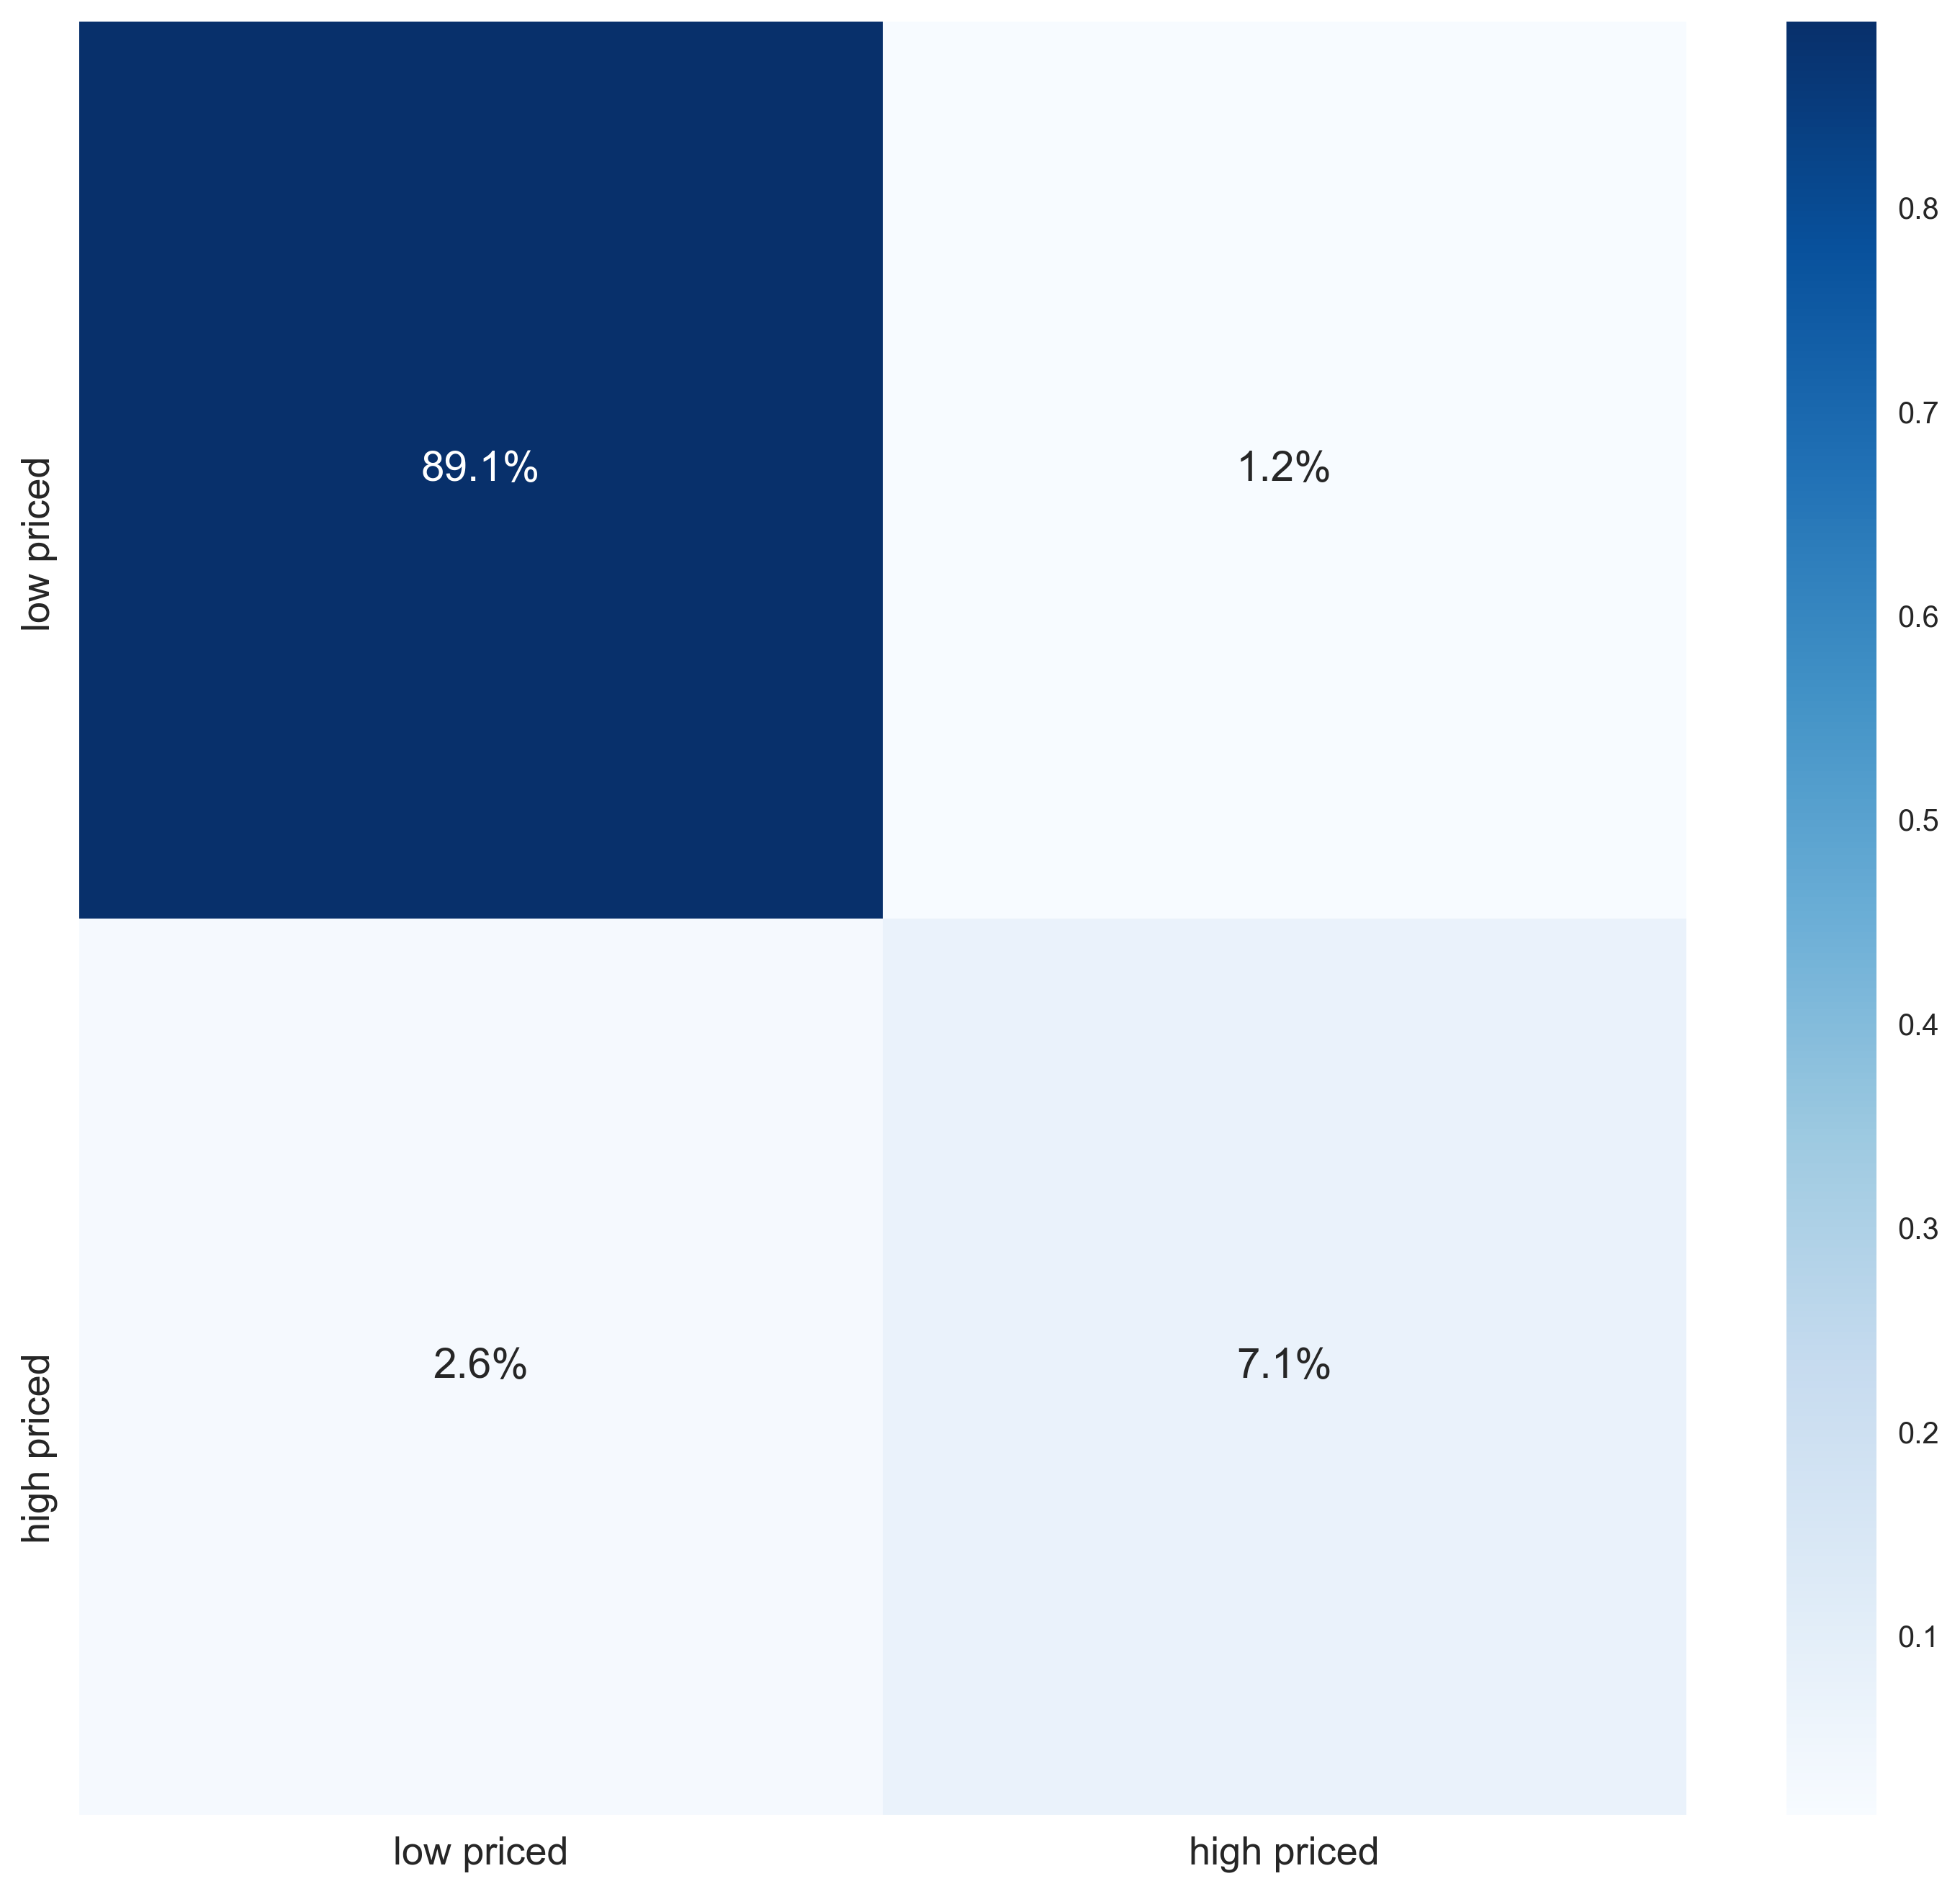

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     53747
         1.0       0.85      0.73      0.79      5743

    accuracy                           0.96     59490
   macro avg       0.91      0.86      0.88     59490
weighted avg       0.96      0.96      0.96     59490



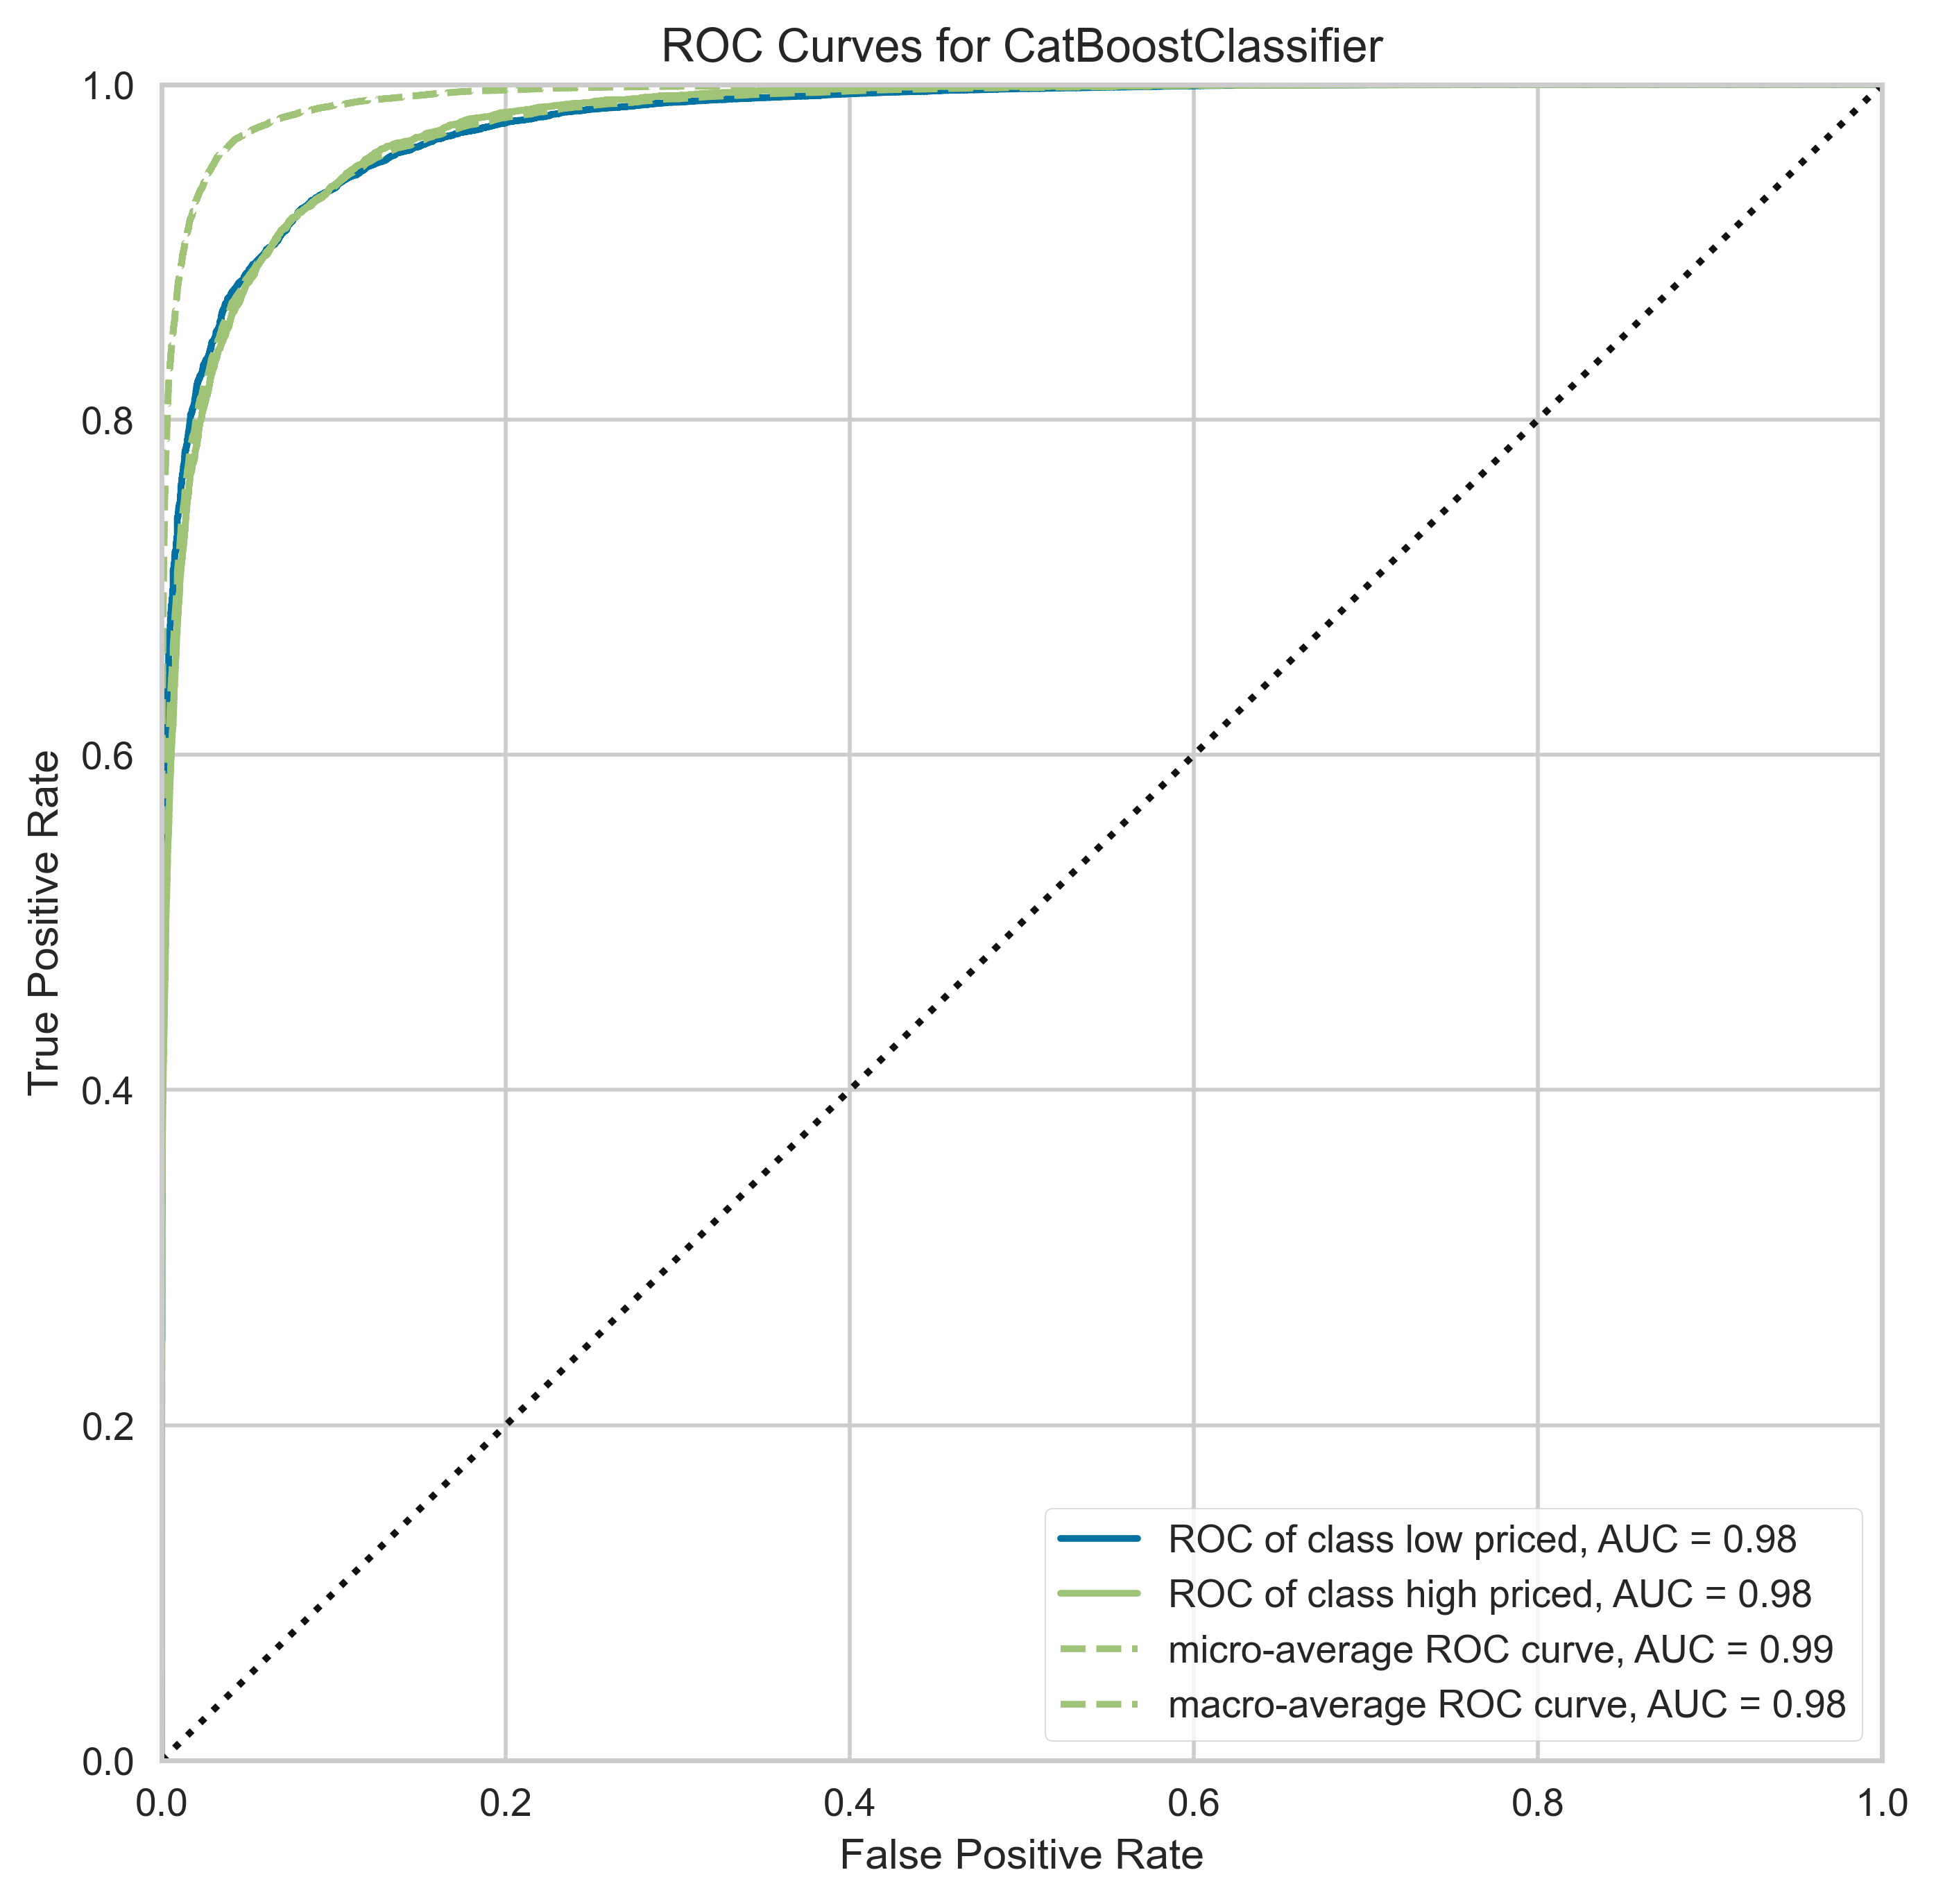

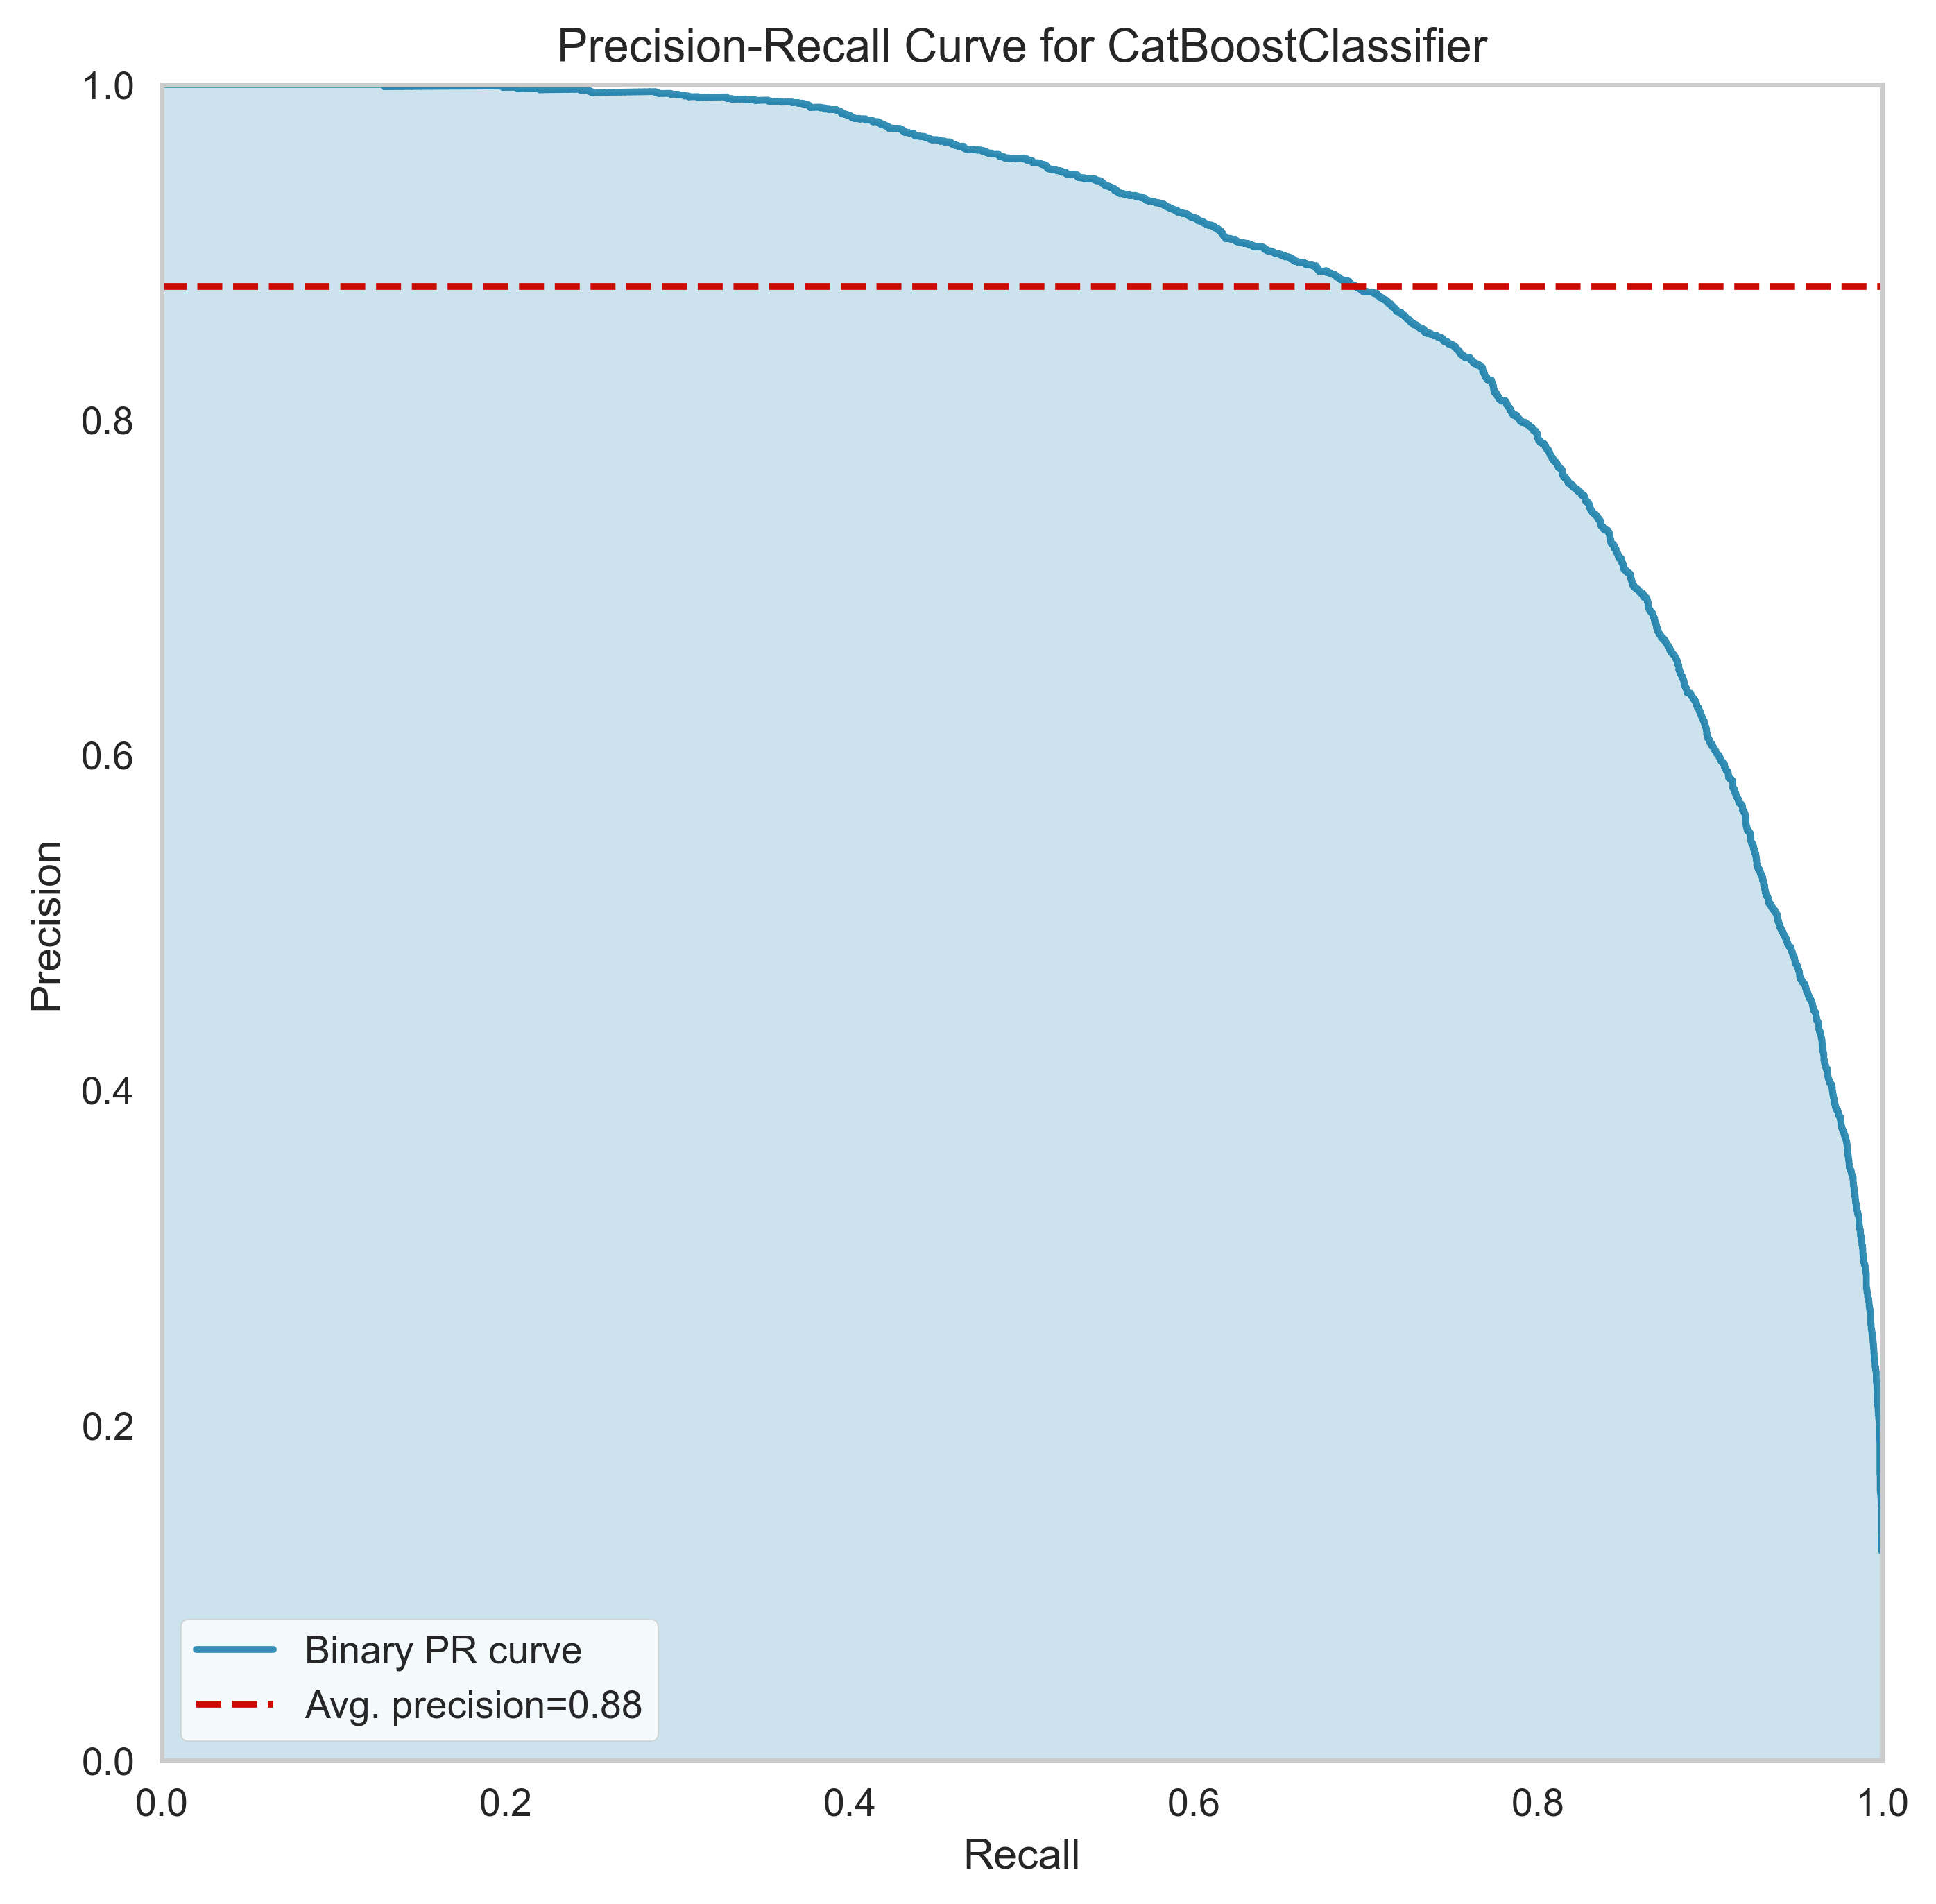

In [7]:
mdl = cb_mdl

y_test_pred = mdl.predict(X_test)
conf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(12, 11), dpi=300)
res = sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, xticklabels=class_l, yticklabels=class_l,\
            fmt='.1%', cmap='Blues', annot_kws={'size':14})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize=13)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=13)
plt.show()

print(metrics.classification_report(y_test, y_test_pred))

plt.figure(figsize = (8,8), dpi=400)
roc_auc = ROCAUC(wrap(mdl), classes=class_l, is_fitted=True)
roc_auc.fit(X_train, y_train)
roc_auc.score(X_test, y_test)
roc_auc.show()
plt.show()

plt.figure(figsize = (8,8), dpi=400)
pr_curve = PrecisionRecallCurve(wrap(mdl), classes=class_l, is_fitted=True)
pr_curve.fit(X_train, y_train)
pr_curve.score(X_test, y_test)
pr_curve.show()
plt.show()

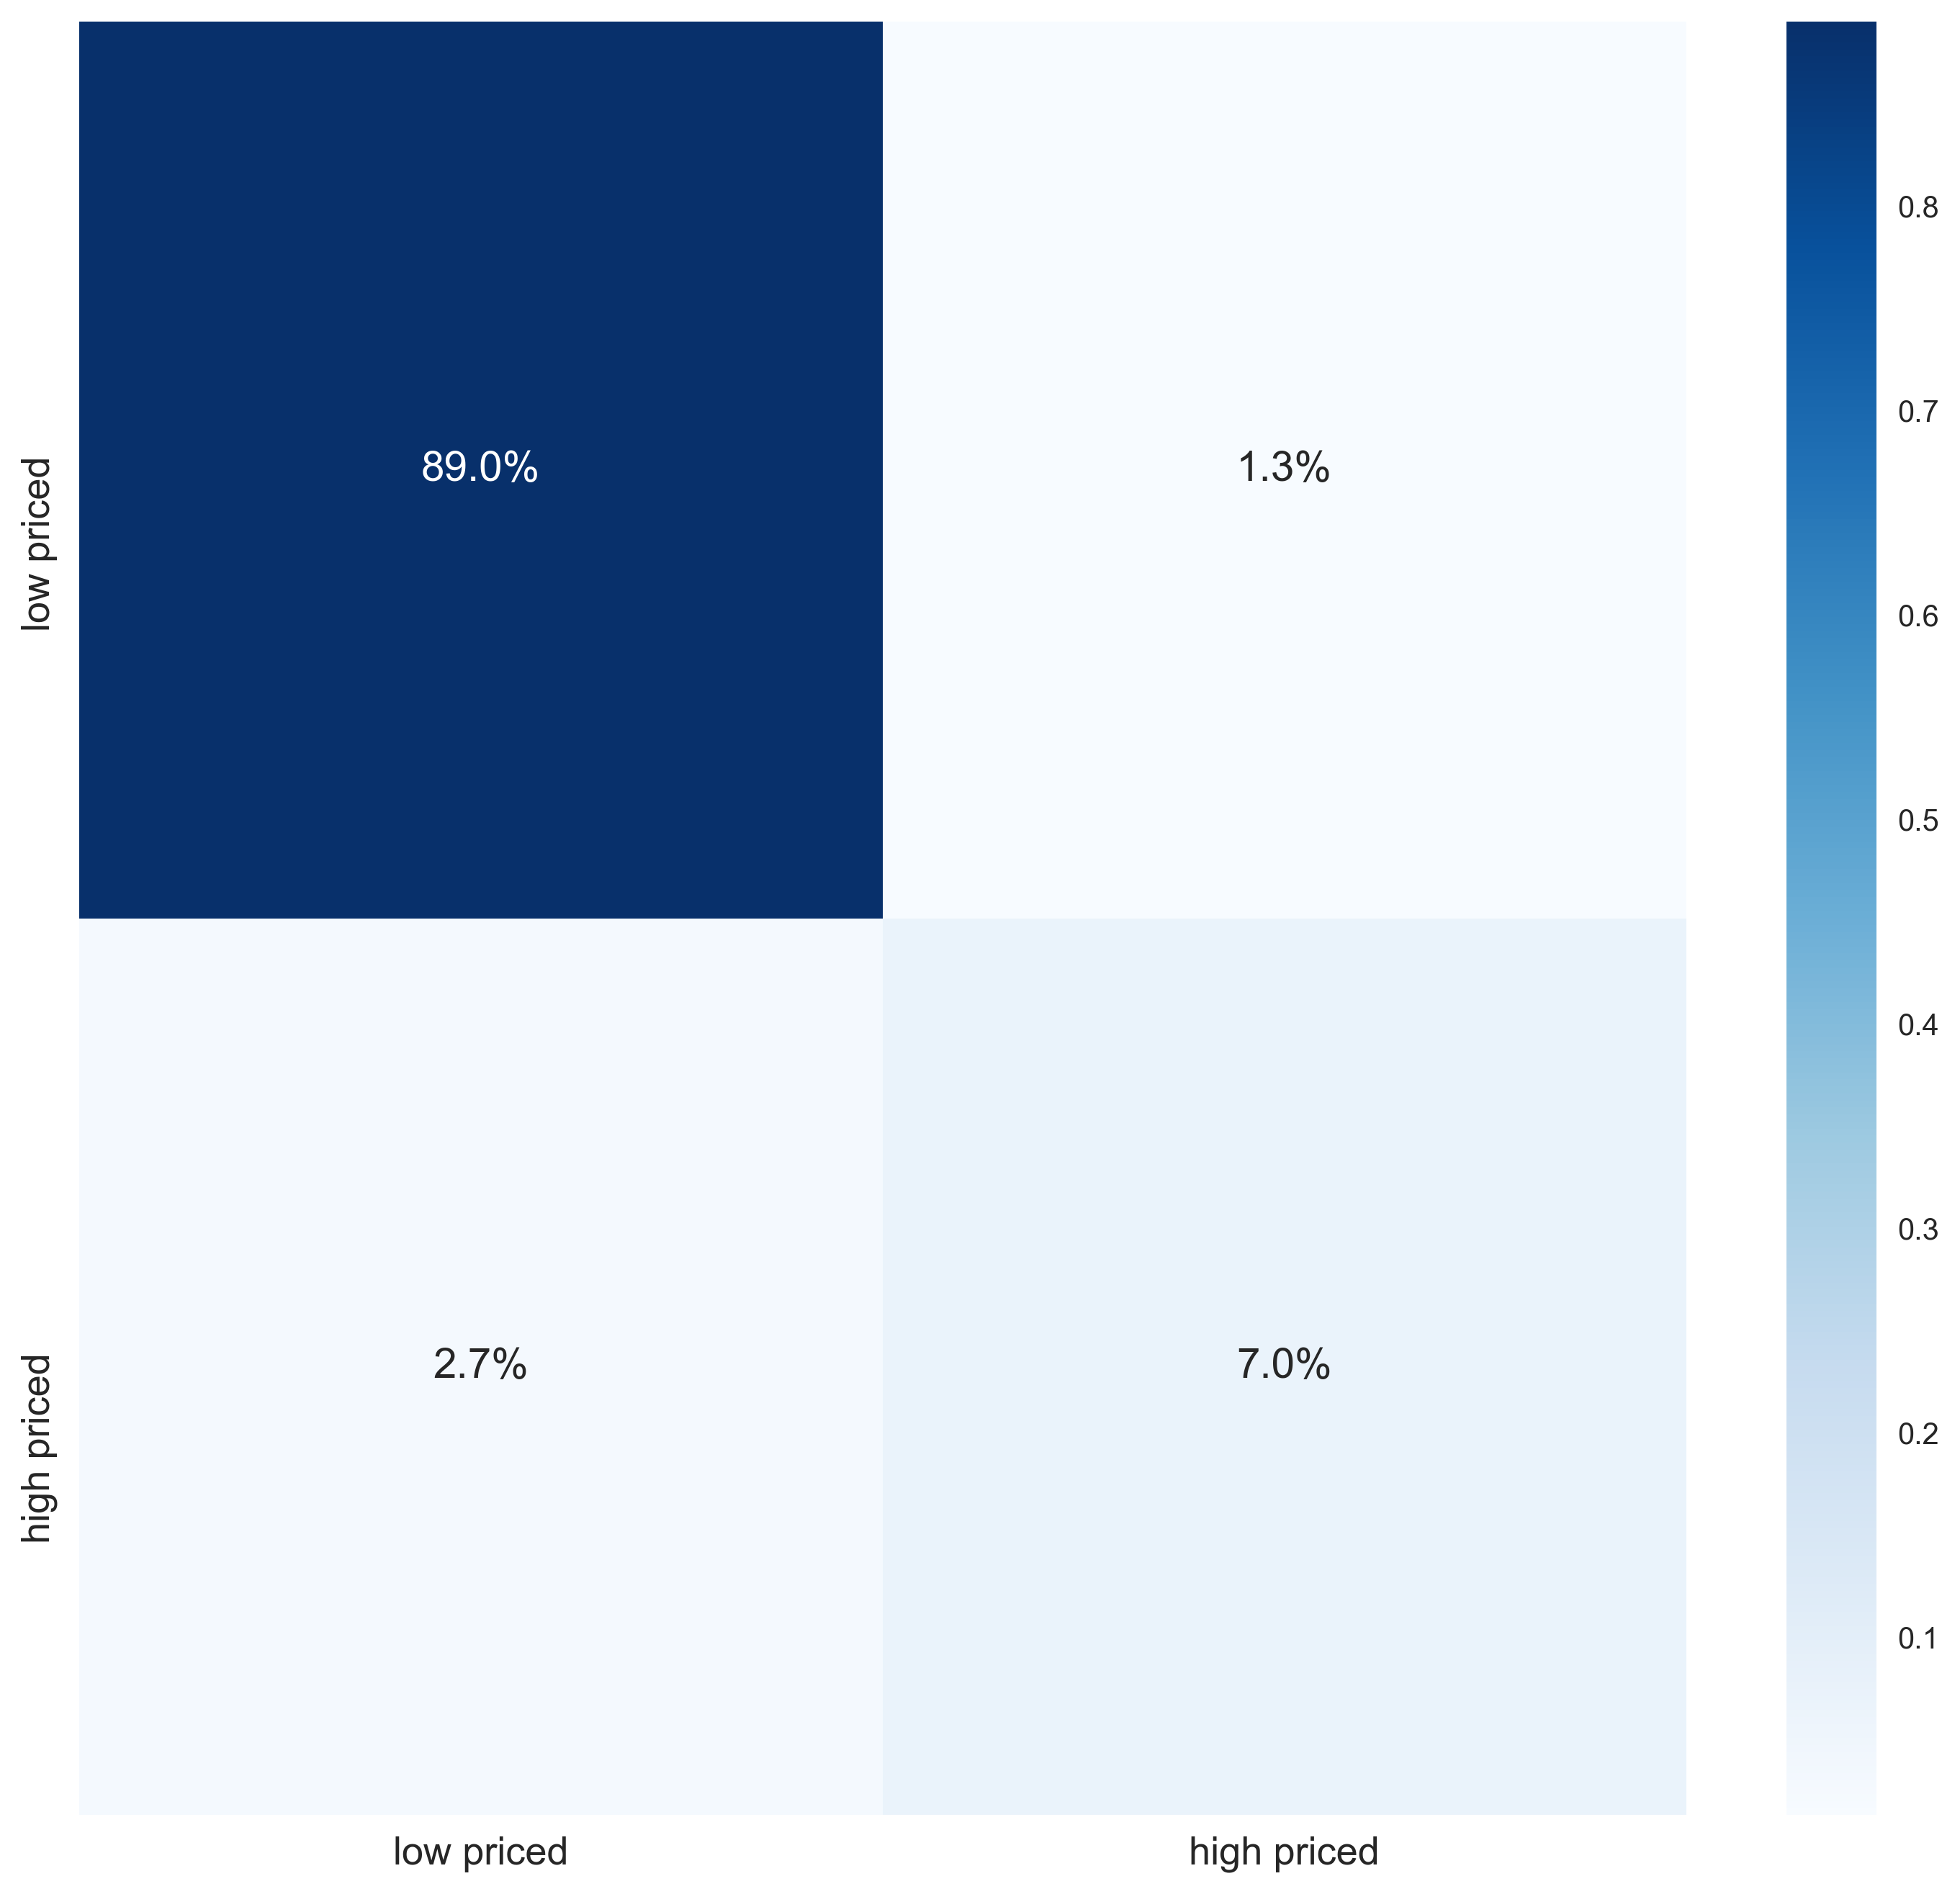

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     53747
         1.0       0.84      0.72      0.78      5743

    accuracy                           0.96     59490
   macro avg       0.91      0.85      0.88     59490
weighted avg       0.96      0.96      0.96     59490



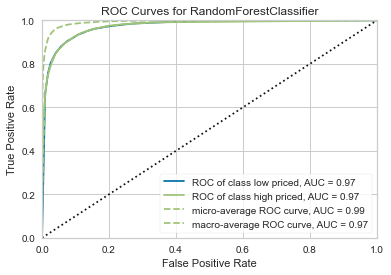

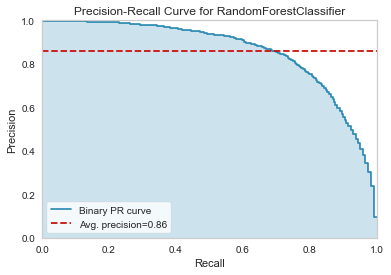

In [8]:
mdl = rf_mdl

y_test_pred = mdl.predict(X_test.to_numpy())
conf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(12, 11), dpi=300)
res = sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True, xticklabels=class_l, yticklabels=class_l,\
            fmt='.1%', cmap='Blues', annot_kws={'size':14})
res.set_xticklabels(res.get_xmajorticklabels(), fontsize=13)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=13)
plt.show()

print(metrics.classification_report(y_test, y_test_pred))

roc_auc = ROCAUC(wrap(mdl), classes=class_l, is_fitted=True)
roc_auc.fit(X_train.to_numpy(), y_train.to_numpy())
roc_auc.score(X_test.to_numpy(), y_test.to_numpy())
roc_auc.show()
plt.show()

pr_curve = PrecisionRecallCurve(wrap(mdl), classes=class_l, is_fitted=True)
pr_curve.fit(X_train.to_numpy(), y_train.to_numpy())
pr_curve.score(X_test.to_numpy(), y_test.to_numpy())
pr_curve.show()
plt.show()

## What is feature importance?

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


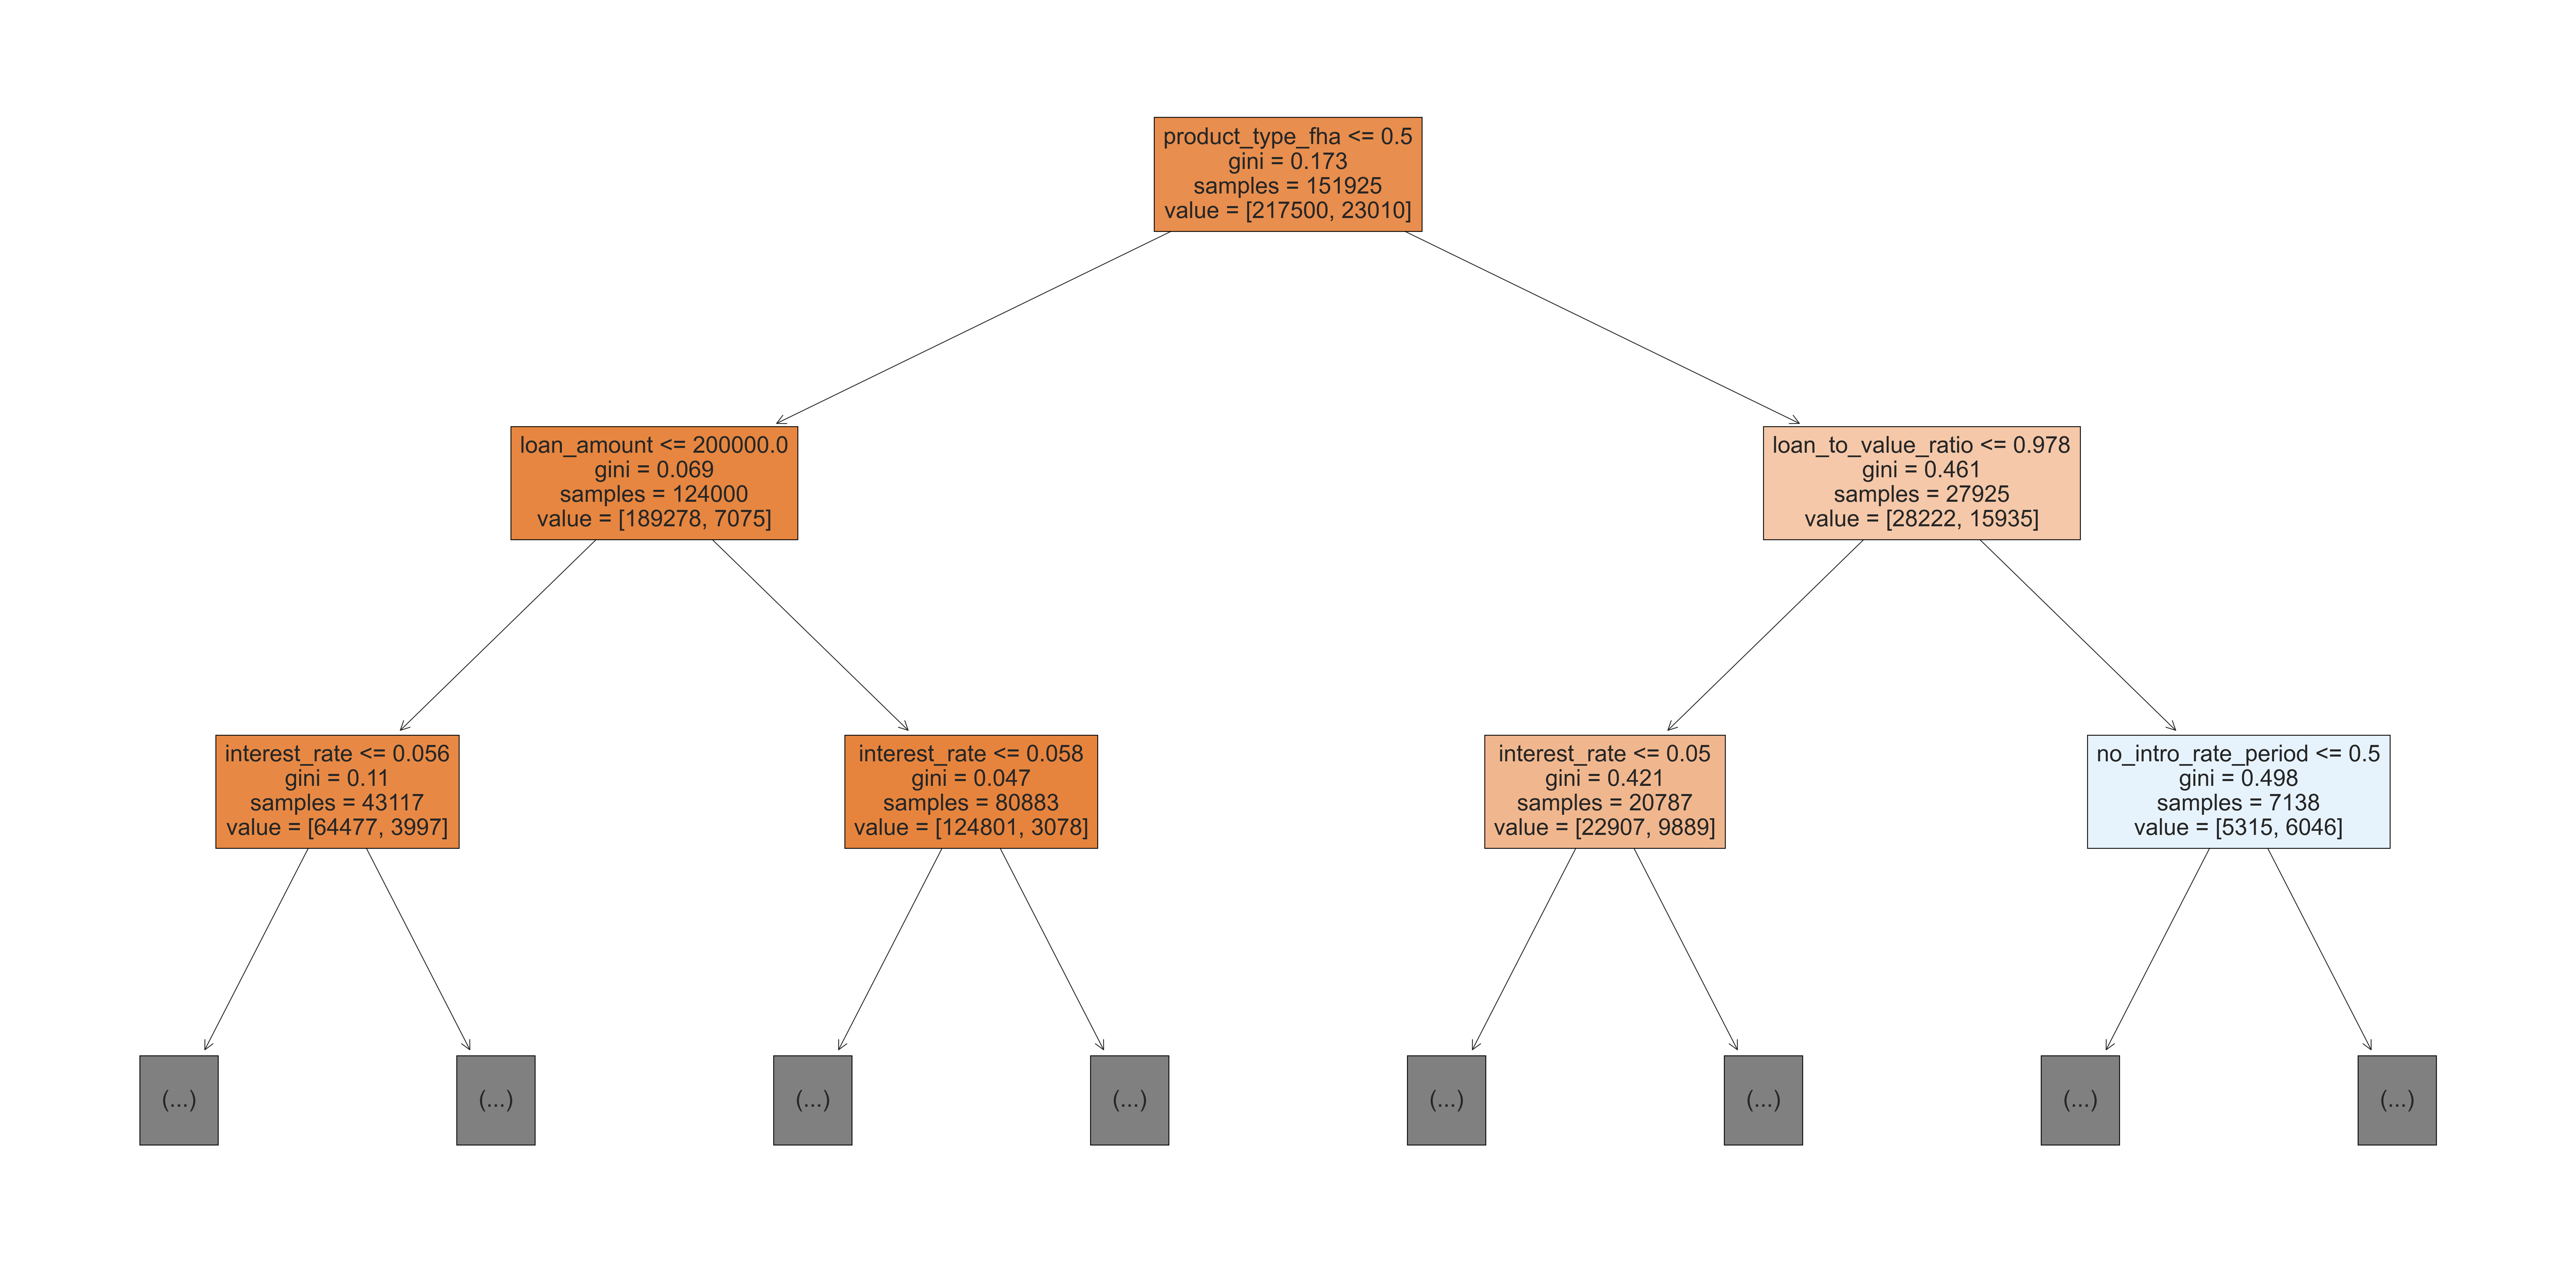

In [9]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=600)
tree.plot_tree(rf_mdl.estimators_[0], feature_names=X_train.columns,\
               filled = True, max_depth=2)
fig.show()

In [10]:
rf_feat_imp = rf_mdl.feature_importances_
print(rf_feat_imp)

[0.40161677 0.05148585 0.09551781 0.00319069 0.00551304 0.05659788
 0.09205562 0.053208   0.00139934 0.00059628 0.06959829 0.02859316
 0.11911408 0.00543087 0.01608232]


In [11]:
cb_feat_imp = cb_mdl.feature_importances_
print(cb_feat_imp)

[23.04405767  4.69461505 20.5815019   0.87793503  3.78725062  5.27570911
  4.64190487  3.09560438  0.67061729  0.66557008  7.50610237  2.45650482
 17.01582504  0.76069592  4.92610584]


In [12]:
pd.set_option("display.precision", 2)
feat_imp_df = pd.DataFrame({'feature':X_train.columns, 'cb_feat_imp':cb_feat_imp,\
                            'rf_feat_imp':rf_feat_imp*100})
feat_imp_df = feat_imp_df.sort_values('cb_feat_imp', ascending=False)
feat_imp_df.style.format('{:.2f}%', subset=['cb_feat_imp', 'rf_feat_imp']).\
                bar(subset=['cb_feat_imp', 'rf_feat_imp'], color='#4EF', width=60)

,feature,cb_feat_imp,rf_feat_imp
0,interest_rate,23.04%,40.16%
2,loan_to_value_ratio,20.58%,9.55%
12,product_type_fha,17.02%,11.91%
10,state_target_encoded,7.51%,6.96%
5,property_value,5.28%,5.66%
14,product_type_va,4.93%,1.61%
1,loan_amount,4.69%,5.15%
6,income,4.64%,9.21%
4,intro_rate_period,3.79%,0.55%
7,debt_to_income_ratio,3.10%,5.32%


## Gauging Feature Importance with Model-agnostic methods

### Permutation Feature Importance

In [13]:
%%time
cb_perm_imp = inspection.permutation_importance(cb_mdl, X_test, y_test, n_repeats=10, random_state=rand)
rf_perm_imp = inspection.permutation_importance(rf_mdl, X_test.to_numpy(), y_test.to_numpy(),\
                                                n_repeats=10, random_state=rand)

CPU times: user 3min 35s, sys: 3.06 s, total: 3min 38s
Wall time: 42 s


In [14]:
pd.set_option("display.precision", 4)
perm_imp_df = pd.DataFrame({'feature':X_train.columns, 'cb_perm_mean':cb_perm_imp.importances_mean,\
                            'cb_perm_std':cb_perm_imp.importances_std,\
                            'rf_perm_mean':rf_perm_imp.importances_mean,\
                            'rf_perm_std':rf_perm_imp.importances_std})
perm_imp_df = perm_imp_df.sort_values('cb_perm_mean', ascending=False)
perm_imp_df.style.format('{:.4f}', subset=['cb_perm_mean', 'cb_perm_std', 'rf_perm_mean', 'rf_perm_std']).\
                bar(subset=['cb_perm_mean', 'rf_perm_mean'], color='#4EF', width=60)

,feature,cb_perm_mean,cb_perm_std,rf_perm_mean,rf_perm_std
0,interest_rate,0.0761,0.0009,0.0754,0.0009
12,product_type_fha,0.0421,0.0008,0.0405,0.0008
1,loan_amount,0.0162,0.0005,0.0006,0.0002
2,loan_to_value_ratio,0.0131,0.0005,0.0104,0.0004
5,property_value,0.0117,0.0006,0.0014,0.0003
10,state_target_encoded,0.0040,0.0003,0.0031,0.0004
8,term_360,0.0026,0.0003,0.0003,0.0001
6,income,0.0018,0.0003,0.0013,0.0004
4,intro_rate_period,0.0016,0.0001,0.0011,0.0001
14,product_type_va,0.0010,0.0002,0.0005,0.0002


### SHAP Values

#### Thorough Explanations with the KernelExplainer

In [ ]:
%%time
rf_fn = lambda x: rf_mdl.predict_proba(x)[:,1]
X_train_summary = shap.kmeans(X_train.to_numpy(), 50)
X_test_sample = X_test.sample(frac=0.05)

rf_kernel_explainer = shap.KernelExplainer(rf_fn, X_train_summary)
rf_shap_values = rf_kernel_explainer.shap_values(X_test_sample.to_numpy())

In [16]:
print(rf_shap_values.shape)

(2974, 15)


#### Quicker Explanations with the TreeExplainer

In [17]:
%%time
cb_tree_explainer = shap.TreeExplainer(cb_mdl)
cb_shap_values = cb_tree_explainer.shap_values(X_test)

CPU times: user 13.8 s, sys: 265 ms, total: 14.1 s
Wall time: 3.01 s


In [18]:
print(cb_shap_values.shape)

(59490, 15)


In [19]:
cb_shap_imp = np.mean(np.abs(cb_shap_values),0)
print(cb_shap_imp)

[1.49770003 0.1985051  1.15186463 0.03249805 0.06703964 0.59225144
 0.2203319  0.13912744 0.04747665 0.06997588 0.29760989 0.07676236
 0.99062317 0.06952701 0.3399137 ]


In [20]:
rf_shap_imp = np.mean(np.abs(rf_shap_values),0)
print(rf_shap_imp)

[0.05242328 0.00769234 0.02359652 0.00118667 0.0013117  0.01154678
 0.00502906 0.00434413 0.00017287 0.00055069 0.00704072 0.00817198
 0.02552453 0.00043547 0.00197792]


In [21]:
pd.set_option("display.precision", 4)
shap_imp_df = pd.DataFrame({'feature':X_train.columns, 'cb_shap_imp':cb_shap_imp,\
                            'rf_shap_imp':rf_shap_imp})
shap_imp_df = shap_imp_df.sort_values('cb_shap_imp', ascending=False)
shap_imp_df.style.format('{:.4f}', subset=['cb_shap_imp', 'rf_shap_imp']).\
                bar(subset=['cb_shap_imp', 'rf_shap_imp'], color='#4EF', width=60)

,feature,cb_shap_imp,rf_shap_imp
0,interest_rate,1.4977,0.0524
2,loan_to_value_ratio,1.1519,0.0236
12,product_type_fha,0.9906,0.0255
5,property_value,0.5923,0.0115
14,product_type_va,0.3399,0.0020
10,state_target_encoded,0.2976,0.0070
6,income,0.2203,0.0050
1,loan_amount,0.1985,0.0077
7,debt_to_income_ratio,0.1391,0.0043
11,product_type_conventional,0.0768,0.0082
